# Clustering ligands from SERT data set

1. Butina clustering (Structural similarity)
2. K-means clustering


In [ ]:
#! pip install pandas numpy seaborn matplotlib rdkit datamol mols2grid sklearn useful_rdkit_utils tqdm

In [1]:
#Essentials for data handle
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas() #useful for progress_apply

#Chemistry data handle
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import Descriptors


#Other chemistry tools
import useful_rdkit_utils as uru
import datamol as dm
import mols2grid

#sci-kit learn tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE

#ploting
import seaborn as sns
sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## 1. Butina Clustering

In [2]:
def ButinaCluster(mol_list, cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)

    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dists.extend([1-x for x in sims])

    mol_clusters = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    cluster_id_list = [0]*nfps

    for idx, cluster in enumerate(mol_clusters, 1):
        for member in cluster:
            cluster_id_list[member] = idx

    return cluster_id_list

In [3]:
#Obtaining clean df from previous exploratory analysis

SERT_clean_data_url = 'https://raw.githubusercontent.com/montserratamion/ChemInformatics_SERT_exploratory_analysis/main/SERT_properties_clean_dataset.csv'

SERT_df = pd.read_csv(SERT_clean_data_url, sep=',')

SERT_df.head()

,Molecule ChEMBL ID,SMILES,class,pIC50,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count
0,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,active,10.096910,329.142722,3.32650,1,4,6,True,4
1,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,active,10.055517,314.154976,4.52840,0,2,7,True,4
2,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,active,9.958607,419.200905,4.19910,3,5,6,True,4
3,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,active,9.886057,267.173548,3.48488,1,3,6,True,4
4,CHEMBL809,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,active,9.850781,305.073805,5.17960,1,1,6,False,3


In [14]:
#making a new df and adding RDkit mol objects and Morgan fingerprints
SERT_cluster_df = SERT_df.copy()
#SERT_cluster_df = SERT_df[['Molecule ChEMBL ID', 'SMILES', 'ro5_count']]
SERT_cluster_df.head()
SERT_cluster_df['mol'] = SERT_cluster_df.SMILES.progress_apply(Chem.MolFromSmiles)
SERT_cluster_df['fp'] = SERT_cluster_df.mol.progress_apply(uru.mol2morgan_fp)

  0%|          | 0/2768 [00:00<?, ?it/s]

  0%|          | 0/2768 [00:00<?, ?it/s]

In [15]:

%time SERT_cluster_df['Cluster'] = ButinaCluster(SERT_cluster_df.mol.values)

CPU times: user 1.25 s, sys: 120 ms, total: 1.37 s
Wall time: 1.39 s


In [16]:
#Visualizing Clustering result and attaching corresponding ChEMBL ID, Cluster, and Ro5
mols2grid.display(SERT_cluster_df, subset=['Molecule ChEMBL ID', 'Cluster', 'ro5_count'])

MolGridWidget()

In [19]:
SERT_cluster_df.head(3)

,Molecule ChEMBL ID,SMILES,class,pIC50,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count,mol,fp,Cluster
0,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,active,10.096910,329.142722,3.3265,1,4,6,True,4,<rdkit.Chem.rdchem.Mol object at 0x7fe3dda429d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1271
1,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,active,10.055517,314.154976,4.5284,0,2,7,True,4,<rdkit.Chem.rdchem.Mol object at 0x7fe3dda42a40>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",574
2,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,active,9.958607,419.200905,4.1991,3,5,6,True,4,<rdkit.Chem.rdchem.Mol object at 0x7fe3dda42ab0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1270


In [21]:
# Clusters are sorted by pIC50 and visualized
SERT_cluster_df.sort_values(['Cluster', 'pIC50'], inplace=True)# , ascending=False

mols2grid.display(SERT_cluster_df, subset=['Molecule ChEMBL ID', 'Cluster','pIC50' ,'ro5_count'], transform={'pIC50': lambda x: f'{x: .2f}'})

MolGridWidget()

In [49]:
SERT_cluster_df.Cluster.describe()

count    2768.000000
mean      366.736272
std       367.246662
min         1.000000
25%        59.000000
50%       228.000000
75%       579.250000
max      1271.000000
Name: Cluster, dtype: float64

- There is 1271 clusters

/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Frequency')

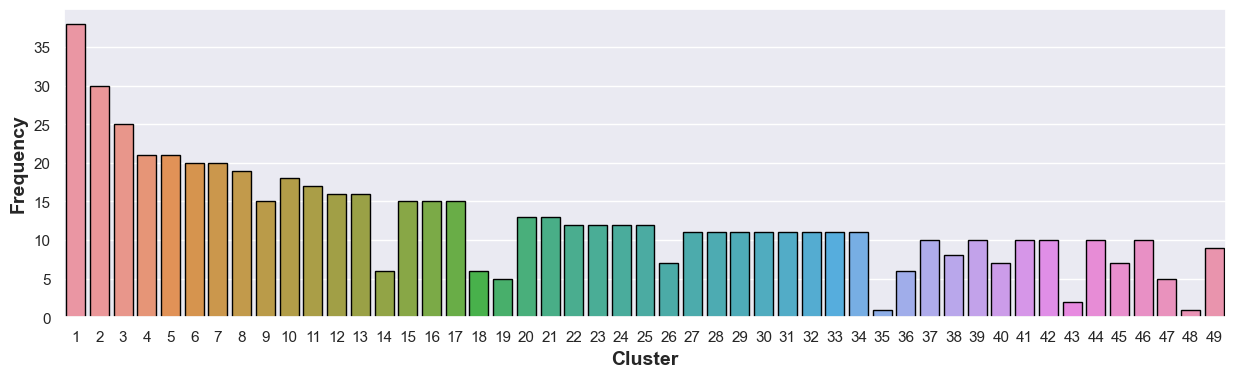

In [50]:
#Ploting the frequency of the best 50 clusters
Best_50_clusters_df = SERT_cluster_df[SERT_cluster_df['Cluster'] < 50] 
plt.figure(figsize=(15, 4))
sns.countplot(x='Cluster', data=Best_5_clusters_df, edgecolor='black')
plt.xlabel('Cluster', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
#Best_5_clusters_df.head()


In [51]:
#Visualizing the structure of the best 50 clusters

SERT_cluster_unique = Best_50_clusters_df.drop_duplicates('Cluster')
mols2grid.display(SERT_cluster_unique, subset=['Molecule ChEMBL ID', 'Cluster','logP' ,'ro5_count'], transform={'logP': lambda x: f'{x: .2f}'})

MolGridWidget()

## 2. K-Means Clustering

In [52]:
SERT_kmeans_df = SERT_df.copy()
SERT_kmeans_df.head()

,Molecule ChEMBL ID,SMILES,class,pIC50,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count
0,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,active,10.096910,329.142722,3.32650,1,4,6,True,4
1,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,active,10.055517,314.154976,4.52840,0,2,7,True,4
2,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,active,9.958607,419.200905,4.19910,3,5,6,True,4
3,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,active,9.886057,267.173548,3.48488,1,3,6,True,4
4,CHEMBL809,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,active,9.850781,305.073805,5.17960,1,1,6,False,3


In [53]:
SERT_kmeans_df['mol'] = SERT_kmeans_df.SMILES.progress_apply(Chem.MolFromSmiles)
SERT_kmeans_df['fp'] = SERT_kmeans_df.mol.progress_apply(uru.mol2morgan_fp)

  0%|          | 0/2768 [00:00<?, ?it/s]

  0%|          | 0/2768 [00:00<?, ?it/s]

In [54]:
#Converting fp to an X matrix

X_matrix = np.stack(SERT_kmeans_df.fp)

### Calculating Silhouette Score to determine the best number of clusters

To determine the optimal value of clusters it is recomended to use:

Silhouette Score (SS) =  $\frac{(b-a)}{max(a,b)}$ 

where :
- **a** is the average intracluster distance

- **b** is the average intercluster distance.  

The Silhouette Score ranges [-1, 1] 

SS --> 1 good match between a point and other members of the same cluster. 

In [55]:
# 1. set a range of cluster numbers to try
clusters = range(5,25)

S_score = []

for ai in clusters:
    km = KMeans(n_clusters=ai, random_state=42,n_init='auto')
    c_labels = km.fit_predict(X_matrix)
    score = silhouette_score(X_matrix,c_labels)
    S_score.append([ai, score])

In [56]:
#Adding S_score to a data frame
Sscore_df = pd.DataFrame(S_score, columns=['K', 'Silhouette Score'])
Sscore_df

,K,Silhouette Score
0,5,0.009255
1,6,0.027287
2,7,0.032645
3,8,0.056034
4,9,0.058199
5,10,0.070742
6,11,0.073361
7,12,0.080115
8,13,0.088452
9,14,0.084594


/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

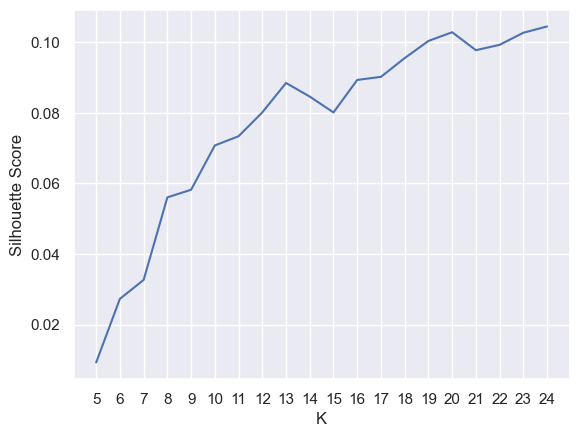

In [57]:
#ploting the scores vs clusters
ax = sns.lineplot(x="K",y="Silhouette Score",data=Sscore_df)
ax.set_xticks(clusters);

In [58]:
num_clusters = 24
km_opt = KMeans(n_clusters=num_clusters, random_state=42, n_init="auto")
clusters_opt = km_opt.fit_predict(X_matrix)

In [59]:
def silhouette_plot(X,cluster_labels):
    """
    Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    sns.set_style('whitegrid')
    sample_df = pd.DataFrame(silhouette_samples(X,cluster_labels),columns=["Silhouette"])
    sample_df['Cluster'] = cluster_labels
    n_clusters = max(cluster_labels+1)
    color_list = [cm.nipy_spectral(float(i) / n_clusters) for i in range(0,n_clusters)]
    ax = sns.scatterplot()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    y_lower = 10
    unique_cluster_ids = sorted(sample_df.Cluster.unique())
    for i in unique_cluster_ids:
        cluster_df = sample_df.query('Cluster == @i')
        cluster_size = len(cluster_df)
        y_upper = y_lower + cluster_size
        ith_cluster_silhouette_values = cluster_df.sort_values("Silhouette").Silhouette.values
        color = color_list[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i),fontsize="small")
        y_lower = y_upper + 10
    ax.axvline(silhouette_avg,color="red",ls="--")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster")
    ax.set(yticklabels=[]) 
    ax.yaxis.grid(False) 

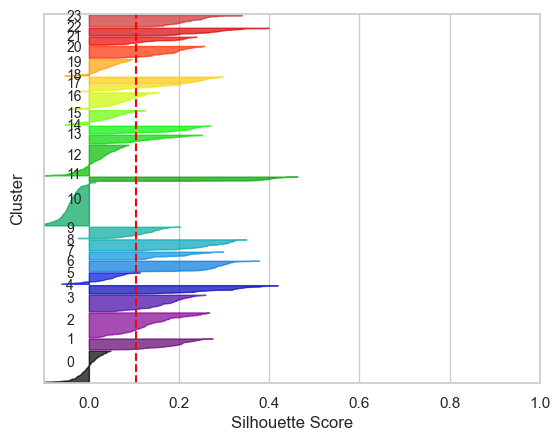

In [60]:
silhouette_plot(X_matrix, clusters_opt)

/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

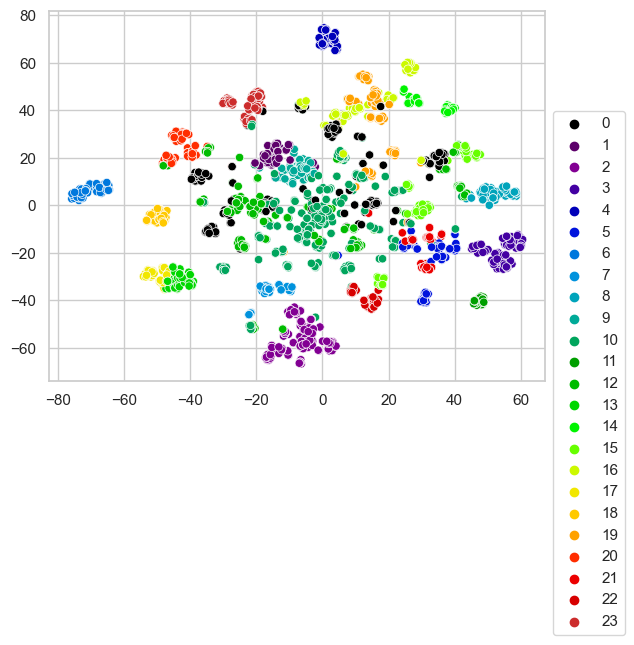

In [61]:
#t-distributed stochastic neighbor embedding (TSNE)
tsne = TSNE(n_components=2, init='pca',learning_rate='auto')
crds = tsne.fit_transform(X_matrix,clusters_opt)
color_list = [cm.nipy_spectral(float(i) / num_clusters) for i in range(0,num_clusters)]
ax = sns.scatterplot(x=crds[:,0],y=crds[:,1],hue=clusters_opt,palette=color_list,legend=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);

In [62]:
opt_cluster_df = SERT_kmeans_df.copy()
opt_cluster_df['Cluster'] = clusters_opt

In [65]:
#To check the structures of each cluster
cluster_id = 0
cols = ["SMILES","Molecule ChEMBL ID","Cluster"]
display_df = opt_cluster_df[cols].query("Cluster == @cluster_id")
mols2grid.display(display_df,subset=["img"],n_cols=3,size=(320,240))

MolGridWidget()

## Conclusions

- Butina clustering is much more efficient to cluster chemical structures in the case of SERT. In the visualizations is clearly observed the structural similarity between the molecules of each cluster. Not the case for k-means.

- Explanation: Butina uses Tanimoto similarity on Morgan fingerprints. K-means depends of the arbitrary number of clusters given and not always the Silhouette score is able to help to perform an efficient clustering.